# A simple LSTM to identify the players in memory

### Links to other LSTM recurrent neural nets
* Character level LSTM in lasagne: https://github.com/Lasagne/Lasagne/blob/master/examples/recurrent.py
* Original post using torch7 / numpy: http://karpathy.github.io/2015/05/21/rnn-effectiveness/
* http://larseidnes.com/2015/10/13/auto-generating-clickbait-with-recurrent-neural-networks/

In [28]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import *
import time
import pandas as pd
import numpy as np

N_LSTM = 64   #Number LSTM units  
N_BATCH = 100  #Batchsize
num_epochs=100  #Number of epchos 
num_inputs  = 4 #Number of features / alphabet of the input sequence

GRAD_CLIP = 100 #Clipping gradient in backpropagation
LEARNING_RATE = 0.01 #Learning rate

There was one class with more than 620 games. We removed some, so that all classes are more balanced

In [2]:
df = pd.read_csv('Zeitreihen_id_mani.csv', sep =" ") 
df[0:4], df.shape

(     id  X2  X3  X4  X5  X6  X7  X8  X9  X10    ...     X29  X30  X31  X32  \
 0  2358   0   0   0   0   0   0   0  -2   -2    ...      -2    1    1   -2   
 1  2359   0   0   0  -2   1   0   0   0   -2    ...       1   -1    1    1   
 2  2360   0   0   0   0   1   0  -2  -2   -1    ...      -2    1    1    0   
 3  2361   0   0   0   0  -1  -2  -1   1   -2    ...       0   -2   -1    1   
 
    X33  X34  X35  X36  X37  playerId  
 0    1   -2    1    0   -1      1327  
 1    1    1   -1   -2    1      1327  
 2   -2   -2    1   -2    1      1327  
 3    1    0    1    0    1      1327  
 
 [4 rows x 38 columns], (1331, 38))

In [3]:
# X.shape 1759
idx_train = 700
idx_val   = 700 + 350

In [4]:
X_ = np.asarray(df.ix[:,'X2':'X37']) + 2 #+2 so that all goes from 0 to 3
y_ = df.ix[:,'playerId']
X_.shape, y_.shape
LENGTH = X_.shape[1] #Length of Sequence

In [5]:
np.histogram(X_, bins=(0,1,2,3,4,5)),set(np.reshape(X_,-1))

((array([10140, 15769, 11677, 10330,     0]), array([0, 1, 2, 3, 4, 5])),
 {0, 1, 2, 3})

In [6]:
y_set = list(set(y_))
num_to_ix = { ch:i for i,ch in enumerate(y_set) }
ix_to_num = { i:ch for i,ch in enumerate(y_set) }
y_d = np.asarray([num_to_ix[y_[i]] for i in range(len(y_))],dtype='int32')
num_classes  = len(ix_to_num) 
np.histogram(y_d, bins=range(30))

(array([ 52,  26,  33,  28, 162,  57,  40,  21,  58,  28,  34,  71, 140,
         47,  52,  26, 194,  93,  21,  52,  96,   0,   0,   0,   0,   0,
          0,   0,   0]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]))

In [7]:
pd.crosstab(y_,1)

col_0,1
playerId,
1327,21
1393,28
1446,28
1568,52
1616,58
1652,140
1883,194
1886,52
1919,96


#### shuffeling
We permute all entries so that there is no order

In [8]:
idx = np.random.permutation(X_.shape[0])
y = y_d[idx]
X = X_[idx]

In [9]:
X.shape

(1331, 36)

In [10]:
def makeCategorical(X_in):
    X_out = np.zeros((X_in.shape[0], X_in.shape[1], num_inputs),dtype='float32')
    for i in range(X_in.shape[0]):
        for j in range(X_in.shape[1]):
            X_out[i,j,X_in[i,j]] = 1
    return X_out

In [11]:
#X_ = np.asarray(np.reshape(X,(X.shape[0],X.shape[1],1)), dtype='float32') #Not categorical

#X_train = X_[0:idx_train,:]
X_train = makeCategorical(X[0:idx_train,:])
y_train = y[0:idx_train]

#X_val = X_[idx_train:idx_val]
X_val = makeCategorical(X[idx_train:idx_val])
y_val = y[idx_train:idx_val]

#X_val = X_[idx_train:idx_val]
X_test = makeCategorical(X[idx_val:])
y_test = y[idx_val:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((700, 36, 4), (700,), (350, 36, 4), (350,), (281, 36, 4), (281,))

### Creation of the network

The input to the network are the sequences of length 36, which are coded as $0 \rightarrow (1,0,0,0)$, $ 1 \rightarrow (0,1,0,0)$. Then comes an LSTM layer with `N_LSTM` units. Each LSTM is replicated in the 36 time steps and thus produces 36 outputs. We take the last output of each unit and feed into a fully connected layer which has 21 outputs reflecting the number of classes.

In [12]:
#We leave the batch size open in the definition of the network
l_in = InputLayer(shape=(None, LENGTH, num_inputs)) #Example: (10, 36, 1)
current_bs = l_in.input_var.shape[0]

l_lstm = LSTMLayer(l_in, N_LSTM, grad_clipping=GRAD_CLIP, nonlinearity=lasagne.nonlinearities.tanh) 
#Shape (Batches, LENGTH, N_LSTM) Example: (10, 36, 12)

#l_lstm_1 =  LSTMLayer(l_lstm, N_LSTM, grad_clipping=GRAD_CLIP, nonlinearity=lasagne.nonlinearities.tanh)

# See https://github.com/Lasagne/Recipes/blob/master/examples/lstm_text_generation.py
# The output of the sliced layer will then be of size (batch_size, N_HIDDEN)
l_shp = lasagne.layers.SliceLayer(l_lstm, -1, 1)
# Shape (10,12)

l_out = DenseLayer(l_shp, num_units=num_classes, W = lasagne.init.Normal(), nonlinearity=lasagne.nonlinearities.softmax) 
#Shape (10, 21)
#l_out = ReshapeLayer(l_dense, (current_bs, LENGTH, num_classes)) #(10, 36, 21)

input = l_in.input_var
print("Defined network ...")

Defined network ...


In [13]:
print("Shapes\n-------\ninput: {}\nLSTM in{} out {}\nSlice Layer in{} out{}\nDense Layer in{} out{}".format(
l_in.shape,
l_lstm.input_shapes,
l_lstm.output_shape,
l_shp.input_shape,
l_shp.output_shape,
l_out.input_shape,
l_out.output_shape))

Shapes
-------
input: (None, 36, 4)
LSTM in[(None, 36, 4)] out (None, 36, 64)
Slice Layer in(None, 36, 64) out(None, 64)
Dense Layer in(None, 64) out(None, 21)


#### Defining functions

We have now defined a network and can define theano functions taking an input and resulting in an output. These functions are then compiled and ready to be executed.

In [14]:
# Testing the network (are the number of layers like what one expects)
preds = theano.function([l_in.input_var], lasagne.layers.get_output(l_out))
Xd = np.asarray(makeCategorical(X[0:10,:]))
res = preds(Xd)
res.shape, res[0], np.sum(res[0])

/Library/Python/2.7/site-packages/theano/scan_module/scan.py:1019: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)
/Library/Python/2.7/site-packages/theano/scan_module/scan_perform_ext.py:135: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


((10, 21),
 array([ 0.04752761,  0.04782593,  0.0475108 ,  0.04759657,  0.0474933 ,
         0.04752894,  0.0477526 ,  0.04767925,  0.04780554,  0.04754256,
         0.0474673 ,  0.04782993,  0.04769564,  0.04772029,  0.04766687,
         0.04761932,  0.04758534,  0.0474903 ,  0.04750217,  0.04769621,
         0.04746355], dtype=float32),
 1.0000001)

### Defining further functions
#### The cost function
We want the cost function to be executed in the graphics card, therefore we have to define a new theano variable `target_values` taking known classes $y=0,1,\ldots,20$. The cost is calcuated as:

In [15]:
# lasagne.layers.get_output produces a variable for the output of the net
target_values = T.ivector('target_output')
network_output = lasagne.layers.get_output(l_out)
cost = T.nnet.categorical_crossentropy(network_output,target_values).mean()
cost_function = theano.function([l_in.input_var, target_values], cost)

In [16]:
#For testing only 
#we have an untrained network, so the costs should be like random
random_loss = cost_function(makeCategorical(X),y)
random_loss

array(3.044667959213257, dtype=float32)

### Updates / Learning
Theano functions can also update values. This is needed if we want to iteratively optimize the parameters of a network.

In [17]:
all_params = lasagne.layers.get_all_params(l_out)
updates = lasagne.updates.adagrad(cost, all_params, LEARNING_RATE)
train = theano.function([l_in.input_var, target_values], cost, updates=updates, allow_input_downcast=True)

In [18]:
test_prediction = lasagne.layers.get_output(l_out, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,target_values)
test_loss = test_loss.mean()
# As a bonus, also create an expression for the classification accuracy:
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_values), dtype=theano.config.floatX)
val_fn = theano.function([l_in.input_var, target_values], [test_loss, test_acc])

In [19]:
test_prediction = lasagne.layers.get_output(l_out, deterministic=True)
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_values))
val_fn = theano.function([l_in.input_var, target_values], [cost, test_acc]) 

In [20]:
############################## Batch iterator ###############################
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order. It assumes
# data is available as numpy arrays. For big datasets, you could load numpy
# arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
# own custom data iteration function. For small datasets, you can also copy
# them to GPU at once for slightly improved performance. This would involve
# several changes in the main program, though, and is not demonstrated here.

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [29]:
import pandas as pd
perf = pd.DataFrame(columns=['train_loss','valid_loss','valid_accuracy'])
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, 100, shuffle=True):
        inputs, targets = batch
        train_err += train(inputs, targets)
        train_batches += 1
        
    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, 250, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1
    
    perf.loc[epoch] = [train_err / train_batches, val_err / val_batches, val_acc / val_batches]
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 100 took 0.673s
  training loss:		2.408975
  validation loss:		2.525304
  validation accuracy:		20.80 %
Epoch 2 of 100 took 0.659s
  training loss:		2.379119
  validation loss:		2.515200
  validation accuracy:		20.80 %
Epoch 3 of 100 took 0.667s
  training loss:		2.383930
  validation loss:		2.511623
  validation accuracy:		19.60 %
Epoch 4 of 100 took 0.661s
  training loss:		2.386268
  validation loss:		2.501831
  validation accuracy:		19.60 %
Epoch 5 of 100 took 0.662s
  training loss:		2.356709
  validation loss:		2.539149
  validation accuracy:		24.00 %
Epoch 6 of 100 took 0.659s
  training loss:		2.356761
  validation loss:		2.520000
  validation accuracy:		20.40 %
Epoch 7 of 100 took 0.660s
  training loss:		2.362840
  validation loss:		2.516549
  validation accuracy:		18.80 %
Epoch 8 of 100 took 0.661s
  training loss:		2.359302
  validation loss:		2.497168
  validation accuracy:		22.40 %
Epoch 9 of 100 took 0.661s
  training loss:		2.333143
  validation loss:		2.4953

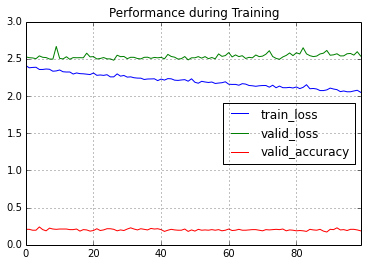

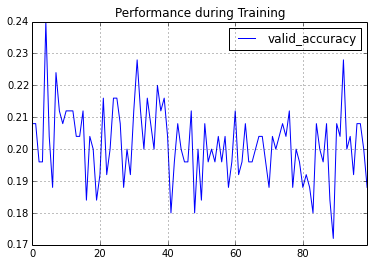

In [30]:
%matplotlib inline
perf[['train_loss','valid_loss','valid_accuracy']].plot(title='Performance during Training')
perf[['valid_accuracy']].plot(title='Performance during Training')

In [31]:
p = preds(X_val) 
np.sum(np.argmax(p,axis=1) == y_val)*1.0/len(y_val)

0.19142857142857142

### Final Evaluation on the test-set

In [32]:
p = preds(X_test)
np.sum(np.argmax(p,axis=1) == y_test)*1.0/len(y_test)

0.24199288256227758

In [33]:
from sklearn.metrics import confusion_matrix
m = confusion_matrix(np.argmax(p,axis=1), y_test)
df = pd.DataFrame(m)
cm_normalized = m.astype('float') / ((m.sum(axis=0)[np.newaxis,:])[0])

In [34]:
diag = [cm_normalized[i,i] for i in range(21)]

In [35]:
np.mean(diag), 1.0/21.0

(0.16172016592184657, 0.047619047619047616)

## Results

All results are given normalized to equal class size:

+ 512 LSTM 12%
+ 128 LSTM 14%
+  64 LSTM 16% 150 runs